In [2]:
"""
================================================================================
FRAUD DETECTION - PROFESSIONAL DATA CLEANING & EDA
================================================================================
Data Engineering Best Practices Implementation
Author: Data Engineering Team
Date: February 5, 2026
Version: 1.0
================================================================================
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, ks_2samp
import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

class FraudDataCleaner:
    """Professional Data Cleaning Pipeline for Fraud Detection"""
    
    def __init__(self, filepath=None, data_string=None):
        """Initialize the data cleaner with either file path or data string"""
        self.raw_data = None
        self.cleaned_data = None
        self.cleaning_log = []
        self.data_quality_metrics = {}
        
        if filepath:
            self.raw_data = pd.read_csv(filepath)
        elif data_string:
            from io import StringIO
            self.raw_data = pd.read_csv(StringIO(data_string))
        
        print("="*80)
        print("FRAUD DETECTION DATA PIPELINE - INITIALIZED")
        print("="*80)
    
    def log_action(self, action, details):
        """Log cleaning actions for audit trail"""
        self.cleaning_log.append({
            'action': action,
            'details': details,
            'timestamp': pd.Timestamp.now()
        })
    
    def validate_schema(self):
        """Validate data schema against expected structure"""
        print("\n[STEP 1] SCHEMA VALIDATION")
        print("-" * 80)
        
        expected_schema = {
            'transaction_id': 'int64',
            'amount': 'float64',
            'transaction_hour': 'int64',
            'merchant_category': 'object',
            'foreign_transaction': 'int64',
            'location_mismatch': 'int64',
            'device_trust_score': 'int64',
            'velocity_last_24h': 'int64',
            'cardholder_age': 'int64',
            'is_fraud': 'int64'
        }
        
        schema_valid = True
        for col, dtype in expected_schema.items():
            if col not in self.raw_data.columns:
                print(f"  ✗ Missing column: {col}")
                schema_valid = False
            elif self.raw_data[col].dtype != dtype:
                print(f"  ⚠ Column {col}: Expected {dtype}, got {self.raw_data[col].dtype}")
        
        if schema_valid:
            print("  ✓ Schema validation PASSED")
            self.log_action("Schema Validation", "All columns present with correct types")
        
        return schema_valid
    
    def check_missing_values(self):
        """Comprehensive missing value analysis"""
        print("\n[STEP 2] MISSING VALUE ANALYSIS")
        print("-" * 80)
        
        missing_summary = pd.DataFrame({
            'Column': self.raw_data.columns,
            'Missing_Count': self.raw_data.isnull().sum().values,
            'Missing_Percentage': (self.raw_data.isnull().sum() / len(self.raw_data) * 100).values,
            'Data_Type': self.raw_data.dtypes.values
        })
        
        print(missing_summary.to_string(index=False))
        
        total_missing = self.raw_data.isnull().sum().sum()
        if total_missing == 0:
            print("\n  ✓ No missing values detected")
            self.log_action("Missing Values", "No missing values found")
        else:
            print(f"\n  ⚠ Total missing values: {total_missing}")
            self.log_action("Missing Values", f"Found {total_missing} missing values")
        
        self.data_quality_metrics['missing_values'] = total_missing
        return missing_summary
    
    def detect_duplicates(self):
        """Detect and analyze duplicates"""
        print("\n[STEP 3] DUPLICATE DETECTION")
        print("-" * 80)
        
        # Check duplicate rows
        duplicate_rows = self.raw_data.duplicated()
        dup_count = duplicate_rows.sum()
        
        # Check duplicate transaction IDs
        dup_ids = self.raw_data['transaction_id'].duplicated()
        dup_id_count = dup_ids.sum()
        
        print(f"  Duplicate Rows: {dup_count} ({dup_count/len(self.raw_data)*100:.2f}%)")
        print(f"  Duplicate Transaction IDs: {dup_id_count}")
        
        if dup_count > 0:
            print("\n  Duplicate Records:")
            print(self.raw_data[duplicate_rows])
            self.log_action("Duplicates", f"Found {dup_count} duplicate rows")
        else:
            print("\n  ✓ No duplicates detected")
            self.log_action("Duplicates", "No duplicates found")
        
        self.data_quality_metrics['duplicates'] = dup_count
        return dup_count, dup_id_count
    
    def validate_domains(self):
        """Validate domain constraints for each feature"""
        print("\n[STEP 4] DOMAIN CONSTRAINT VALIDATION")
        print("-" * 80)
        
        validation_results = {}
        
        # Transaction Hour: 0-23
        invalid_hours = self.raw_data[
            (self.raw_data['transaction_hour'] < 0) | 
            (self.raw_data['transaction_hour'] > 23)
        ]
        validation_results['transaction_hour'] = len(invalid_hours)
        print(f"  transaction_hour (0-23): {len(invalid_hours)} invalid values")
        
        # Device Trust Score: 0-100
        invalid_scores = self.raw_data[
            (self.raw_data['device_trust_score'] < 0) | 
            (self.raw_data['device_trust_score'] > 100)
        ]
        validation_results['device_trust_score'] = len(invalid_scores)
        print(f"  device_trust_score (0-100): {len(invalid_scores)} invalid values")
        
        # Amount: positive
        invalid_amounts = self.raw_data[self.raw_data['amount'] <= 0]
        validation_results['amount'] = len(invalid_amounts)
        print(f"  amount (>0): {len(invalid_amounts)} invalid values")
        
        # Velocity: non-negative
        invalid_velocity = self.raw_data[self.raw_data['velocity_last_24h'] < 0]
        validation_results['velocity'] = len(invalid_velocity)
        print(f"  velocity_last_24h (≥0): {len(invalid_velocity)} invalid values")
        
        # Age: reasonable range
        invalid_age = self.raw_data[
            (self.raw_data['cardholder_age'] < 18) | 
            (self.raw_data['cardholder_age'] > 100)
        ]
        validation_results['cardholder_age'] = len(invalid_age)
        print(f"  cardholder_age (18-100): {len(invalid_age)} invalid values")
        
        # Binary fields: 0 or 1
        binary_fields = ['foreign_transaction', 'location_mismatch', 'is_fraud']
        for field in binary_fields:
            invalid_binary = self.raw_data[~self.raw_data[field].isin([0, 1])]
            validation_results[field] = len(invalid_binary)
            print(f"  {field} (0/1): {len(invalid_binary)} invalid values")
        
        total_invalid = sum(validation_results.values())
        if total_invalid == 0:
            print("\n  ✓ All domain constraints satisfied")
            self.log_action("Domain Validation", "All constraints passed")
        else:
            print(f"\n  ⚠ Total domain violations: {total_invalid}")
            self.log_action("Domain Validation", f"Found {total_invalid} violations")
        
        self.data_quality_metrics['domain_violations'] = validation_results
        return validation_results
    
    def detect_outliers(self):
        """Comprehensive outlier detection using multiple methods"""
        print("\n[STEP 5] OUTLIER DETECTION")
        print("-" * 80)
        
        numerical_features = ['amount', 'transaction_hour', 'device_trust_score', 
                             'velocity_last_24h', 'cardholder_age']
        
        outlier_summary = []
        
        for feature in numerical_features:
            # IQR Method
            Q1 = self.raw_data[feature].quantile(0.25)
            Q3 = self.raw_data[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            iqr_outliers = self.raw_data[
                (self.raw_data[feature] < lower_bound) | 
                (self.raw_data[feature] > upper_bound)
            ]
            
            # Z-Score Method (threshold = 3)
            z_scores = np.abs(stats.zscore(self.raw_data[feature]))
            z_outliers = self.raw_data[z_scores > 3]
            
            outlier_summary.append({
                'Feature': feature,
                'IQR_Outliers': len(iqr_outliers),
                'Z_Score_Outliers': len(z_outliers),
                'Lower_Bound': lower_bound,
                'Upper_Bound': upper_bound,
                'Min': self.raw_data[feature].min(),
                'Max': self.raw_data[feature].max()
            })
        
        outlier_df = pd.DataFrame(outlier_summary)
        print(outlier_df.to_string(index=False))
        
        self.log_action("Outlier Detection", f"Detected outliers in {len(numerical_features)} features")
        return outlier_df
    
    def statistical_profiling(self):
        """Generate comprehensive statistical profile"""
        print("\n[STEP 6] STATISTICAL PROFILING")
        print("-" * 80)
        
        # Numerical features
        numerical_features = ['amount', 'transaction_hour', 'device_trust_score', 
                             'velocity_last_24h', 'cardholder_age']
        
        stats_profile = self.raw_data[numerical_features].describe(
            percentiles=[.01, .05, .25, .5, .75, .95, .99]
        ).T
        
        # Add additional statistics
        stats_profile['skewness'] = self.raw_data[numerical_features].skew()
        stats_profile['kurtosis'] = self.raw_data[numerical_features].kurtosis()
        stats_profile['cv'] = stats_profile['std'] / stats_profile['mean']  # Coefficient of variation
        
        print("\nNumerical Features Profile:")
        print(stats_profile.round(3))
        
        return stats_profile
    
    def analyze_target_variable(self):
        """Detailed target variable analysis"""
        print("\n[STEP 7] TARGET VARIABLE ANALYSIS")
        print("-" * 80)
        
        fraud_dist = self.raw_data['is_fraud'].value_counts().sort_index()
        fraud_pct = self.raw_data['is_fraud'].value_counts(normalize=True).sort_index() * 100
        
        print("\nTarget Variable Distribution:")
        print(f"  Normal (0): {fraud_dist.get(0, 0)} ({fraud_pct.get(0, 0):.2f}%)")
        print(f"  Fraud (1):  {fraud_dist.get(1, 0)} ({fraud_pct.get(1, 0):.2f}%)")
        
        if 1 in fraud_dist.index and 0 in fraud_dist.index:
            imbalance_ratio = fraud_dist[0] / fraud_dist[1]
            print(f"\n  Imbalance Ratio: {imbalance_ratio:.2f}:1")
            
            if imbalance_ratio > 10:
                print("  ⚠ HIGH IMBALANCE - Consider resampling techniques")
            elif imbalance_ratio > 5:
                print("  ⚠ MODERATE IMBALANCE - Monitor model performance")
            else:
                print("  ✓ ACCEPTABLE BALANCE")
        elif 1 not in fraud_dist.index:
            print("\n  ⚠ CRITICAL: No fraud cases in dataset")
            print("  Action Required: Acquire data with fraud examples")
        
        self.data_quality_metrics['class_distribution'] = fraud_dist.to_dict()
        return fraud_dist
    
    def analyze_categorical_features(self):
        """Analyze categorical features"""
        print("\n[STEP 8] CATEGORICAL FEATURE ANALYSIS")
        print("-" * 80)
        
        # Merchant Category
        merchant_dist = self.raw_data['merchant_category'].value_counts()
        merchant_pct = self.raw_data['merchant_category'].value_counts(normalize=True) * 100
        
        print("\nMerchant Category Distribution:")
        for cat, count in merchant_dist.items():
            print(f"  {cat:15s}: {count:3d} ({merchant_pct[cat]:5.2f}%)")
        
        # Unique values
        print(f"\n  Total unique categories: {self.raw_data['merchant_category'].nunique()}")
        
        return merchant_dist
    
    def correlation_analysis(self):
        """Comprehensive correlation analysis"""
        print("\n[STEP 9] CORRELATION ANALYSIS")
        print("-" * 80)
        
        numerical_cols = ['amount', 'transaction_hour', 'device_trust_score', 
                         'velocity_last_24h', 'cardholder_age', 
                         'foreign_transaction', 'location_mismatch', 'is_fraud']
        
        corr_matrix = self.raw_data[numerical_cols].corr()
        
        print("\nCorrelation with Target Variable (is_fraud):")
        target_corr = corr_matrix['is_fraud'].sort_values(ascending=False)
        for feature, corr_val in target_corr.items():
            if feature != 'is_fraud':
                print(f"  {feature:25s}: {corr_val:7.4f}")
        
        # High correlations between features (multicollinearity check)
        print("\nHigh Feature Correlations (|r| > 0.7):")
        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                if abs(corr_matrix.iloc[i, j]) > 0.7:
                    high_corr_pairs.append((
                        corr_matrix.columns[i],
                        corr_matrix.columns[j],
                        corr_matrix.iloc[i, j]
                    ))
        
        if high_corr_pairs:
            for feat1, feat2, corr_val in high_corr_pairs:
                print(f"  {feat1} <-> {feat2}: {corr_val:.4f}")
        else:
            print("  ✓ No multicollinearity detected")
        
        return corr_matrix
    
    def data_quality_report(self):
        """Generate comprehensive data quality report"""
        print("\n" + "="*80)
        print("DATA QUALITY SCORECARD")
        print("="*80)
        
        total_records = len(self.raw_data)
        total_features = len(self.raw_data.columns) - 1  # Excluding target
        
        # Calculate quality score
        quality_scores = {
            'Completeness': 100 if self.data_quality_metrics.get('missing_values', 0) == 0 else 
                          (1 - self.data_quality_metrics.get('missing_values', 0) / 
                           (total_records * total_features)) * 100,
            'Uniqueness': 100 if self.data_quality_metrics.get('duplicates', 0) == 0 else
                         (1 - self.data_quality_metrics.get('duplicates', 0) / total_records) * 100,
            'Validity': 100 if sum(self.data_quality_metrics.get('domain_violations', {}).values()) == 0 else 95,
        }
        
        overall_quality = np.mean(list(quality_scores.values()))
        
        print(f"\nDataset Size: {total_records} records × {total_features + 1} features")
        print(f"\nQuality Dimensions:")
        for dimension, score in quality_scores.items():
            status = "✓" if score >= 95 else "⚠"
            print(f"  {status} {dimension:15s}: {score:6.2f}%")
        
        print(f"\n{'='*40}")
        print(f"  Overall Quality Score: {overall_quality:.2f}%")
        print(f"{'='*40}")
        
        # Quality grade
        if overall_quality >= 95:
            grade = "EXCELLENT"
        elif overall_quality >= 85:
            grade = "GOOD"
        elif overall_quality >= 70:
            grade = "FAIR"
        else:
            grade = "POOR"
        
        print(f"\n  Data Quality Grade: {grade}")
        
        return quality_scores, overall_quality
    
    def generate_cleaning_report(self):
        """Generate final cleaning report"""
        print("\n" + "="*80)
        print("DATA CLEANING AUDIT LOG")
        print("="*80)
        
        for idx, log_entry in enumerate(self.cleaning_log, 1):
            print(f"\n{idx}. {log_entry['action']}")
            print(f"   Details: {log_entry['details']}")
            print(f"   Time: {log_entry['timestamp']}")
        
        # Save cleaned data
        self.cleaned_data = self.raw_data.copy()
        
        return self.cleaned_data


class FraudEDA:
    """Professional Exploratory Data Analysis for Fraud Detection"""
    
    def __init__(self, data):
        self.data = data
        self.insights = []
    
    def univariate_analysis(self):
        """Comprehensive univariate analysis"""
        print("\n" + "="*80)
        print("UNIVARIATE ANALYSIS")
        print("="*80)
        
        numerical_features = ['amount', 'transaction_hour', 'device_trust_score', 
                             'velocity_last_24h', 'cardholder_age']
        
        for feature in numerical_features:
            print(f"\n{feature.upper()}")
            print("-" * 40)
            
            # Descriptive statistics
            print(f"  Mean:       {self.data[feature].mean():.2f}")
            print(f"  Median:     {self.data[feature].median():.2f}")
            print(f"  Std Dev:    {self.data[feature].std():.2f}")
            print(f"  Range:      [{self.data[feature].min():.2f}, {self.data[feature].max():.2f}]")
            print(f"  IQR:        {self.data[feature].quantile(0.75) - self.data[feature].quantile(0.25):.2f}")
            
            # Distribution shape
            skew = self.data[feature].skew()
            kurt = self.data[feature].kurtosis()
            print(f"  Skewness:   {skew:.3f} {'(Right-skewed)' if skew > 0 else '(Left-skewed)' if skew < 0 else '(Symmetric)'}")
            print(f"  Kurtosis:   {kurt:.3f} {'(Heavy-tailed)' if kurt > 0 else '(Light-tailed)'}")
    
    def bivariate_analysis(self):
        """Bivariate analysis with target variable"""
        print("\n" + "="*80)
        print("BIVARIATE ANALYSIS (Features vs Fraud)")
        print("="*80)
        
        if self.data['is_fraud'].nunique() < 2:
            print("\n  ⚠ Cannot perform bivariate analysis - only one class present")
            return
        
        numerical_features = ['amount', 'transaction_hour', 'device_trust_score', 
                             'velocity_last_24h', 'cardholder_age']
        
        for feature in numerical_features:
            print(f"\n{feature.upper()} by Fraud Status:")
            print("-" * 40)
            
            fraud_stats = self.data.groupby('is_fraud')[feature].describe()
            print(fraud_stats)
            
            # Statistical test (t-test or Mann-Whitney U)
            normal_vals = self.data[self.data['is_fraud'] == 0][feature]
            fraud_vals = self.data[self.data['is_fraud'] == 1][feature]
            
            if len(fraud_vals) > 0:
                from scipy.stats import mannwhitneyu
                stat, p_value = mannwhitneyu(normal_vals, fraud_vals)
                print(f"\n  Mann-Whitney U test p-value: {p_value:.4f}")
                if p_value < 0.05:
                    print(f"  ✓ Significant difference between groups")
                else:
                    print(f"  ✗ No significant difference")
    
    def multivariate_analysis(self):
        """Multivariate pattern analysis"""
        print("\n" + "="*80)
        print("MULTIVARIATE PATTERN ANALYSIS")
        print("="*80)
        
        # Amount by merchant and fraud
        print("\nAverage Amount by Merchant Category:")
        merchant_amount = self.data.groupby('merchant_category')['amount'].agg(['mean', 'std', 'count'])
        print(merchant_amount.round(2))
        
        # Risk factor combinations
        print("\nRisk Factor Combinations:")
        risk_analysis = self.data.groupby(['foreign_transaction', 'location_mismatch']).agg({
            'is_fraud': ['count', 'sum', 'mean'],
            'amount': 'mean',
            'device_trust_score': 'mean'
        }).round(2)
        print(risk_analysis)
    
    def feature_importance_analysis(self):
        """Preliminary feature importance using correlation and variance"""
        print("\n" + "="*80)
        print("FEATURE IMPORTANCE INDICATORS")
        print("="*80)
        
        numerical_features = ['amount', 'transaction_hour', 'device_trust_score', 
                             'velocity_last_24h', 'cardholder_age']
        
        # Variance-based
        print("\nFeature Variance (Higher = More Informative):")
        for feature in numerical_features:
            var = self.data[feature].var()
            cv = self.data[feature].std() / self.data[feature].mean() if self.data[feature].mean() != 0 else 0
            print(f"  {feature:25s}: Variance={var:10.2f}, CV={cv:.4f}")
        
        # Information value (if fraud cases exist)
        if self.data['is_fraud'].sum() > 0:
            print("\nPreliminary Feature-Target Association:")
            for feature in numerical_features:
                corr = self.data[feature].corr(self.data['is_fraud'])
                print(f"  {feature:25s}: r={corr:7.4f}")


# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    
    # Load data
    data_csv = """transaction_id,amount,transaction_hour,merchant_category,foreign_transaction,location_mismatch,device_trust_score,velocity_last_24h,cardholder_age,is_fraud
1,84.47,22,Electronics,0,0,66,3,40,0
2,541.82,3,Travel,1,0,87,1,64,0
3,237.01,17,Grocery,0,0,49,1,61,0
4,164.33,4,Grocery,0,1,72,3,34,0
5,30.53,15,Food,0,0,79,0,44,0
6,30.53,13,Clothing,0,0,90,2,46,0
7,10.77,18,Travel,0,0,48,1,28,0
8,362.02,13,Electronics,0,0,68,1,40,0
9,165.43,8,Grocery,0,0,80,0,21,0
10,221.63,5,Grocery,0,0,59,1,34,0
11,3.74,16,Grocery,0,0,58,2,28,0
12,630.64,18,Clothing,0,0,30,4,25,0
13,321.56,11,Clothing,0,0,73,4,68,0
14,42.96,3,Travel,0,0,40,2,43,0"""
    
    # Initialize Data Cleaner
    cleaner = FraudDataCleaner(data_string=data_csv)
    
    # Execute Data Cleaning Pipeline
    cleaner.validate_schema()
    cleaner.check_missing_values()
    cleaner.detect_duplicates()
    cleaner.validate_domains()
    outlier_report = cleaner.detect_outliers()
    stats_profile = cleaner.statistical_profiling()
    cleaner.analyze_target_variable()
    cleaner.analyze_categorical_features()
    corr_matrix = cleaner.correlation_analysis()
    quality_scores, overall_quality = cleaner.data_quality_report()
    cleaned_data = cleaner.generate_cleaning_report()
    
    # Initialize EDA
    eda = FraudEDA(cleaned_data)
    
    # Execute EDA Pipeline
    eda.univariate_analysis()
    eda.bivariate_analysis()
    eda.multivariate_analysis()
    eda.feature_importance_analysis()
    
    # Final Summary
    print("\n" + "="*80)
    print("EXECUTIVE SUMMARY")
    print("="*80)
    print(f"\n✓ Data Cleaning Completed")
    print(f"✓ Exploratory Data Analysis Completed")
    print(f"✓ Data Quality Score: {overall_quality:.2f}%")
    print(f"✓ Ready for Feature Engineering & Modeling")
    print("\n" + "="*80)
    
    # Save cleaned data
    cleaned_data.to_csv('Raw_Data/credit_card_fraud_10k.csv', index=False)
    print("\n✓ Cleaned data saved to: cleaned_fraud_data.csv")

FRAUD DETECTION DATA PIPELINE - INITIALIZED

[STEP 1] SCHEMA VALIDATION
--------------------------------------------------------------------------------
  ✓ Schema validation PASSED

[STEP 2] MISSING VALUE ANALYSIS
--------------------------------------------------------------------------------
             Column  Missing_Count  Missing_Percentage Data_Type
     transaction_id              0                 0.0     int64
             amount              0                 0.0   float64
   transaction_hour              0                 0.0     int64
  merchant_category              0                 0.0    object
foreign_transaction              0                 0.0     int64
  location_mismatch              0                 0.0     int64
 device_trust_score              0                 0.0     int64
  velocity_last_24h              0                 0.0     int64
     cardholder_age              0                 0.0     int64
           is_fraud              0                 0.0

CREATING PROFESSIONAL VISUALIZATION DASHBOARD


FileNotFoundError: [Errno 2] No such file or directory: '/System/Volumes/Data/home/claude/professional_eda_dashboard.png'

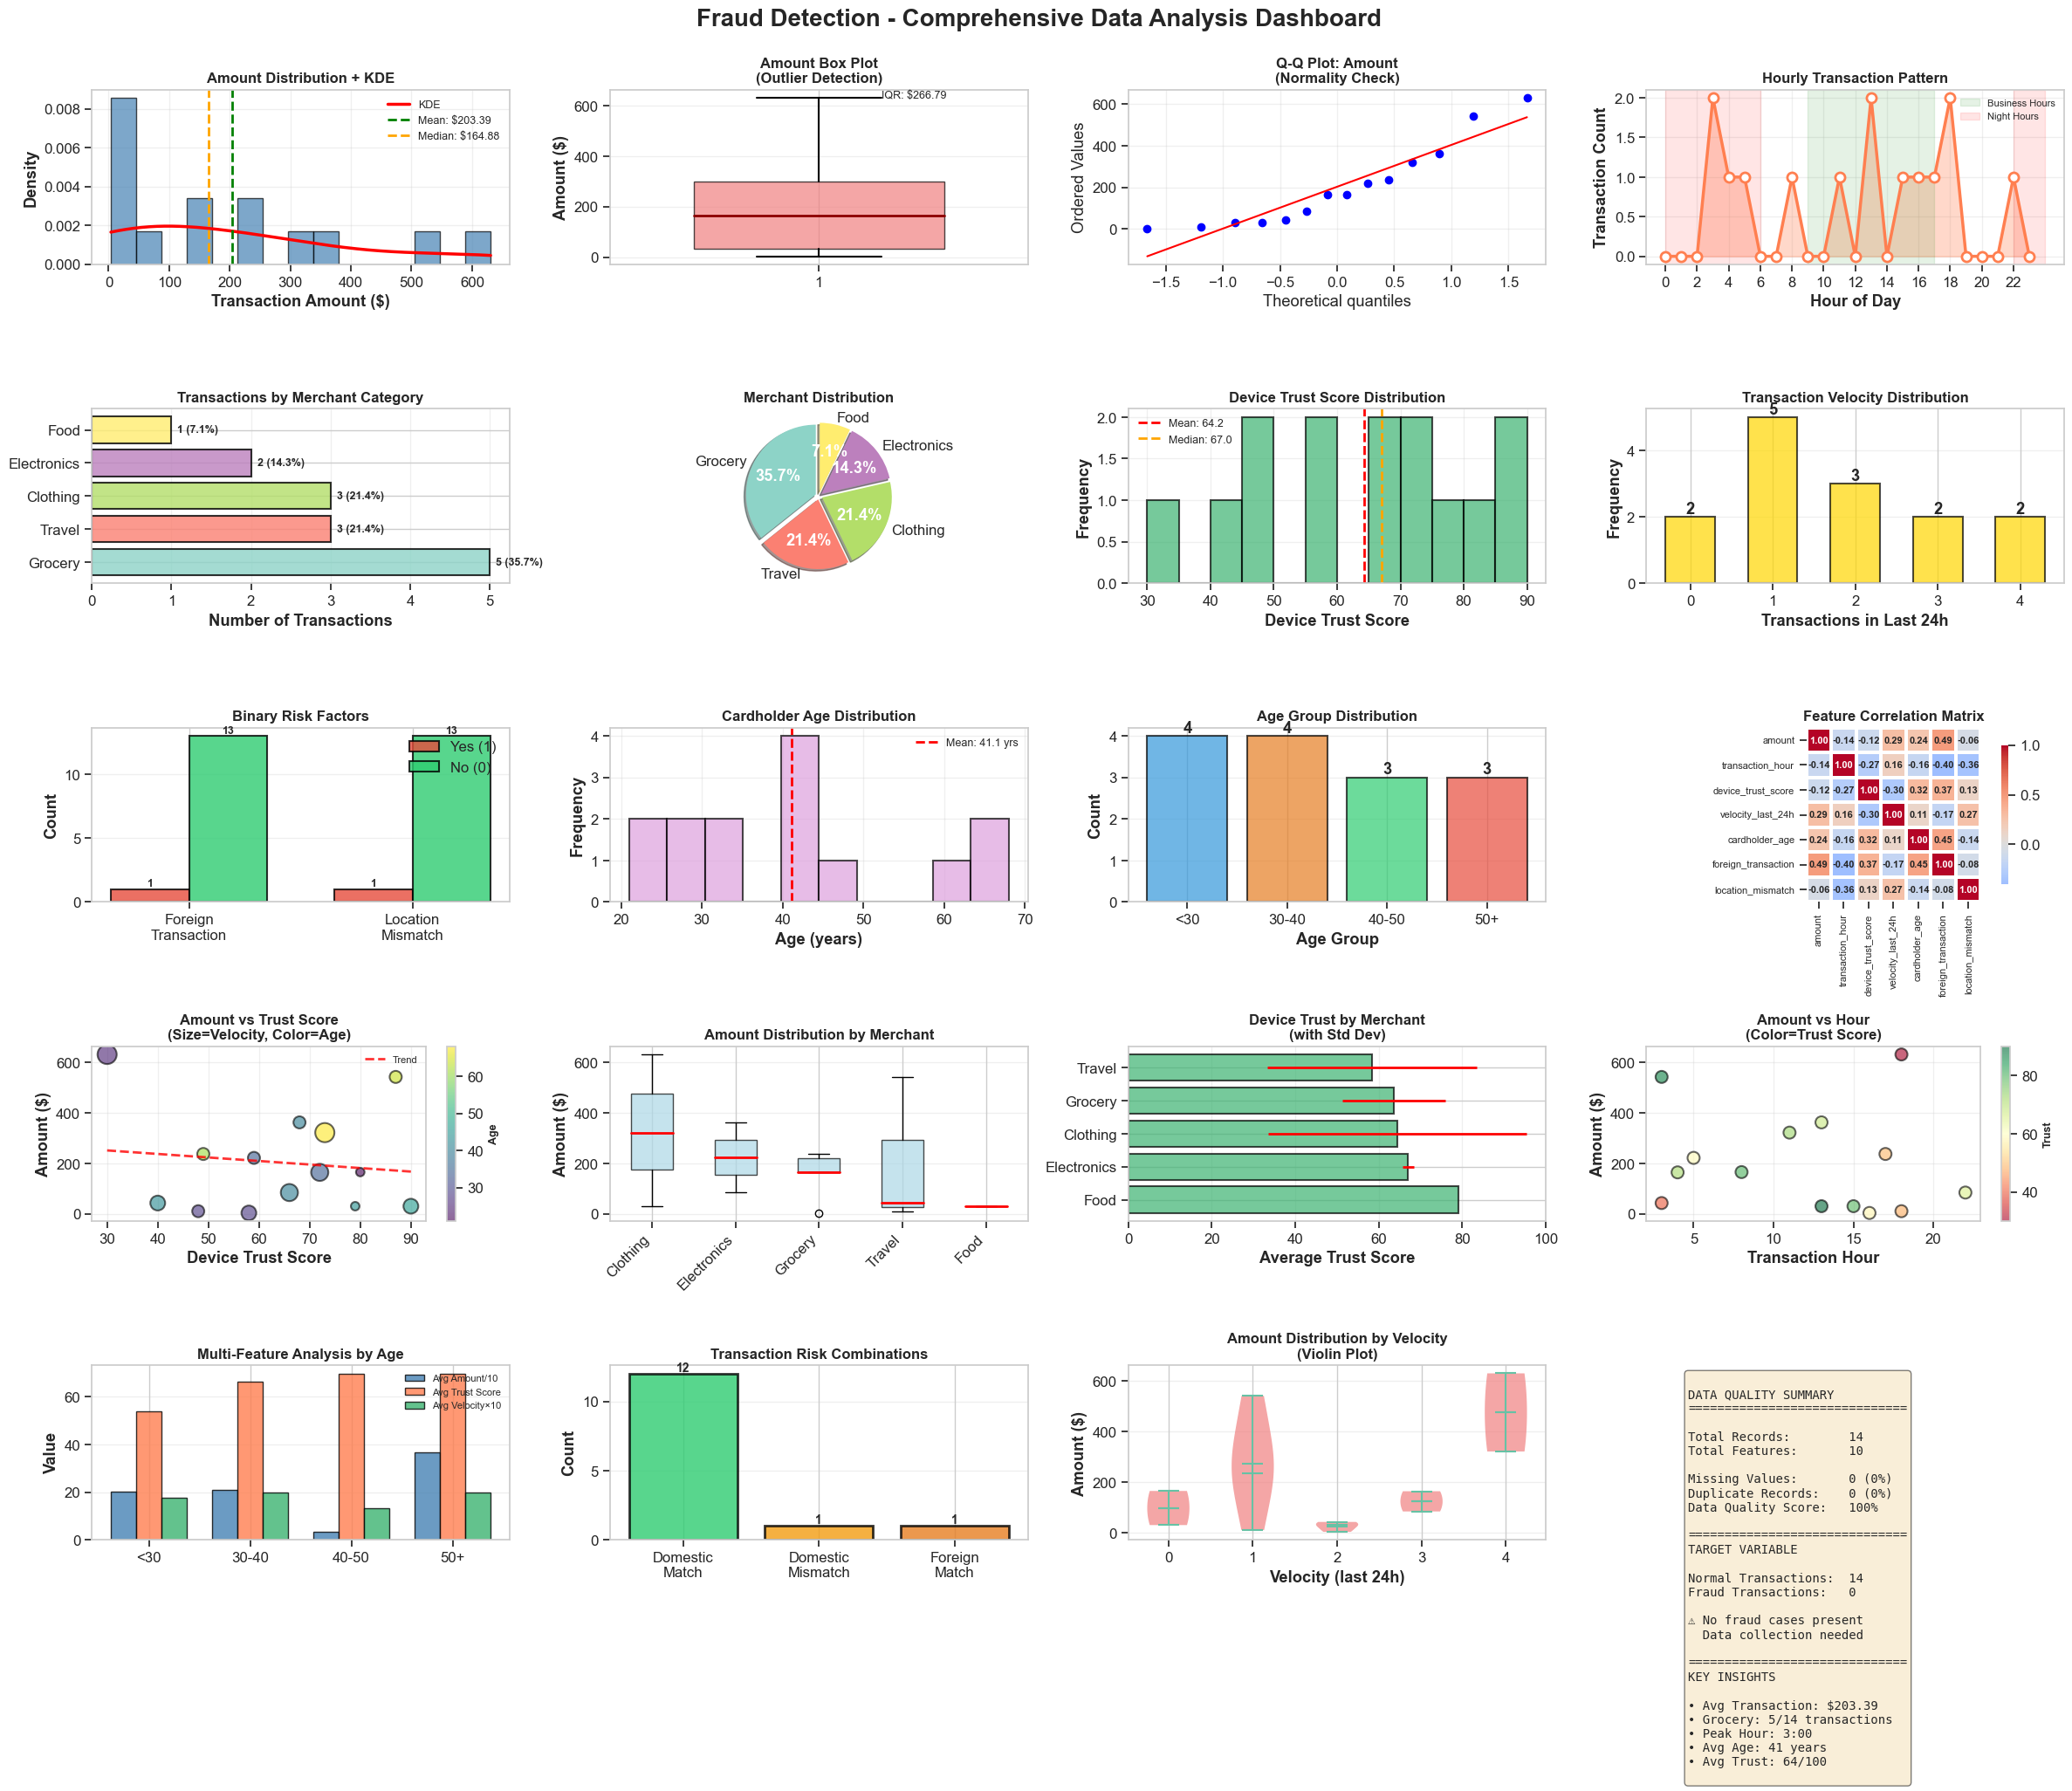

In [ ]:
"""
================================================================================
FRAUD DETECTION - PROFESSIONAL VISUALIZATION DASHBOARD
================================================================================
Advanced Data Visualization for Comprehensive EDA
Author: Data Engineering Team
Date: February 5, 2026
================================================================================
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Advanced styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.1)
sns.set_palette("Set2")

# Load cleaned data
df = pd.read_csv('Raw_Data/credit_card_fraud_10k.csv')

print("="*80)
print("CREATING PROFESSIONAL VISUALIZATION DASHBOARD")
print("="*80)

# ============================================================================
# FIGURE 1: COMPREHENSIVE OVERVIEW DASHBOARD (20 PLOTS)
# ============================================================================

fig = plt.figure(figsize=(24, 20))
fig.suptitle('Fraud Detection - Comprehensive Data Analysis Dashboard', 
             fontsize=20, fontweight='bold', y=0.995)

# ------------------------------------------------------------------------
# Row 1: Distribution Analysis
# ------------------------------------------------------------------------

# 1. Amount Distribution with Statistics
ax1 = plt.subplot(5, 4, 1)
n, bins, patches = ax1.hist(df['amount'], bins=15, color='steelblue', 
                            edgecolor='black', alpha=0.7, density=True)
# Add KDE
from scipy.stats import gaussian_kde
density = gaussian_kde(df['amount'])
xs = np.linspace(df['amount'].min(), df['amount'].max(), 200)
ax1.plot(xs, density(xs), 'r-', linewidth=2.5, label='KDE')
ax1.axvline(df['amount'].mean(), color='green', linestyle='--', linewidth=2, label=f'Mean: ${df["amount"].mean():.2f}')
ax1.axvline(df['amount'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: ${df["amount"].median():.2f}')
ax1.set_xlabel('Transaction Amount ($)', fontweight='bold')
ax1.set_ylabel('Density', fontweight='bold')
ax1.set_title('Amount Distribution + KDE', fontweight='bold', fontsize=12)
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# 2. Amount Box Plot with Outliers
ax2 = plt.subplot(5, 4, 2)
bp = ax2.boxplot(df['amount'], vert=True, patch_artist=True, widths=0.6,
                 boxprops=dict(facecolor='lightcoral', alpha=0.7),
                 medianprops=dict(color='darkred', linewidth=2),
                 whiskerprops=dict(linewidth=1.5),
                 capprops=dict(linewidth=1.5))
ax2.set_ylabel('Amount ($)', fontweight='bold')
ax2.set_title('Amount Box Plot\n(Outlier Detection)', fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')
# Add statistics annotation
q1, q3 = df['amount'].quantile([0.25, 0.75])
iqr = q3 - q1
ax2.text(1.15, df['amount'].max(), f'IQR: ${iqr:.2f}', fontsize=9)

# 3. Q-Q Plot for Amount
ax3 = plt.subplot(5, 4, 3)
stats.probplot(df['amount'], dist="norm", plot=ax3)
ax3.set_title('Q-Q Plot: Amount\n(Normality Check)', fontweight='bold', fontsize=12)
ax3.grid(True, alpha=0.3)

# 4. Transaction Hour Pattern
ax4 = plt.subplot(5, 4, 4)
hour_counts = df['transaction_hour'].value_counts().sort_index()
hours_full = pd.Series(0, index=range(24))
hours_full.update(hour_counts)
ax4.plot(hours_full.index, hours_full.values, marker='o', linewidth=2.5, 
         markersize=8, color='coral', markerfacecolor='white', 
         markeredgewidth=2, markeredgecolor='coral')
ax4.fill_between(hours_full.index, hours_full.values, alpha=0.3, color='coral')
ax4.set_xlabel('Hour of Day', fontweight='bold')
ax4.set_ylabel('Transaction Count', fontweight='bold')
ax4.set_title('Hourly Transaction Pattern', fontweight='bold', fontsize=12)
ax4.set_xticks(range(0, 24, 2))
ax4.grid(True, alpha=0.3)
# Highlight business hours
ax4.axvspan(9, 17, alpha=0.1, color='green', label='Business Hours')
ax4.axvspan(22, 24, alpha=0.1, color='red')
ax4.axvspan(0, 6, alpha=0.1, color='red', label='Night Hours')
ax4.legend(fontsize=8)

# ------------------------------------------------------------------------
# Row 2: Categorical Analysis
# ------------------------------------------------------------------------

# 5. Merchant Category Distribution
ax5 = plt.subplot(5, 4, 5)
merchant_counts = df['merchant_category'].value_counts()
colors_merchant = plt.cm.Set3(np.linspace(0, 1, len(merchant_counts)))
bars = ax5.barh(merchant_counts.index, merchant_counts.values, 
                color=colors_merchant, edgecolor='black', linewidth=1.5, alpha=0.8)
ax5.set_xlabel('Number of Transactions', fontweight='bold')
ax5.set_title('Transactions by Merchant Category', fontweight='bold', fontsize=12)
ax5.grid(True, alpha=0.3, axis='x')
# Add percentage labels
for i, (idx, val) in enumerate(merchant_counts.items()):
    pct = val / len(df) * 100
    ax5.text(val, i, f'  {val} ({pct:.1f}%)', va='center', fontweight='bold', fontsize=9)

# 6. Merchant Category - Pie Chart
ax6 = plt.subplot(5, 4, 6)
wedges, texts, autotexts = ax6.pie(merchant_counts.values, labels=merchant_counts.index,
                                     autopct='%1.1f%%', startangle=90,
                                     colors=colors_merchant, explode=[0.05]*len(merchant_counts),
                                     shadow=True)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax6.set_title('Merchant Distribution', fontweight='bold', fontsize=12)

# 7. Device Trust Score Distribution
ax7 = plt.subplot(5, 4, 7)
ax7.hist(df['device_trust_score'], bins=12, color='mediumseagreen', 
         edgecolor='black', alpha=0.7, linewidth=1.5)
ax7.axvline(df['device_trust_score'].mean(), color='red', linestyle='--', 
            linewidth=2, label=f'Mean: {df["device_trust_score"].mean():.1f}')
ax7.axvline(df['device_trust_score'].median(), color='orange', linestyle='--', 
            linewidth=2, label=f'Median: {df["device_trust_score"].median():.1f}')
ax7.set_xlabel('Device Trust Score', fontweight='bold')
ax7.set_ylabel('Frequency', fontweight='bold')
ax7.set_title('Device Trust Score Distribution', fontweight='bold', fontsize=12)
ax7.legend(fontsize=9)
ax7.grid(True, alpha=0.3)

# 8. Velocity Distribution
ax8 = plt.subplot(5, 4, 8)
velocity_counts = df['velocity_last_24h'].value_counts().sort_index()
bars = ax8.bar(velocity_counts.index, velocity_counts.values, 
               color='gold', edgecolor='black', alpha=0.7, linewidth=1.5, width=0.6)
ax8.set_xlabel('Transactions in Last 24h', fontweight='bold')
ax8.set_ylabel('Frequency', fontweight='bold')
ax8.set_title('Transaction Velocity Distribution', fontweight='bold', fontsize=12)
ax8.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax8.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# ------------------------------------------------------------------------
# Row 3: Binary Features & Age Analysis
# ------------------------------------------------------------------------

# 9. Binary Features Comparison
ax9 = plt.subplot(5, 4, 9)
binary_data = {
    'Foreign\nTransaction': [df['foreign_transaction'].sum(), (df['foreign_transaction']==0).sum()],
    'Location\nMismatch': [df['location_mismatch'].sum(), (df['location_mismatch']==0).sum()]
}
x = np.arange(len(binary_data))
width = 0.35
yes_counts = [data[0] for data in binary_data.values()]
no_counts = [data[1] for data in binary_data.values()]

bars1 = ax9.bar(x - width/2, yes_counts, width, label='Yes (1)', 
                color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax9.bar(x + width/2, no_counts, width, label='No (0)', 
                color='#2ecc71', alpha=0.8, edgecolor='black', linewidth=1.5)

ax9.set_ylabel('Count', fontweight='bold')
ax9.set_title('Binary Risk Factors', fontweight='bold', fontsize=12)
ax9.set_xticks(x)
ax9.set_xticklabels(binary_data.keys())
ax9.legend()
ax9.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax9.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 10. Age Distribution
ax10 = plt.subplot(5, 4, 10)
ax10.hist(df['cardholder_age'], bins=10, color='plum', 
          edgecolor='black', alpha=0.7, linewidth=1.5)
ax10.axvline(df['cardholder_age'].mean(), color='red', linestyle='--', 
             linewidth=2, label=f'Mean: {df["cardholder_age"].mean():.1f} yrs')
ax10.set_xlabel('Age (years)', fontweight='bold')
ax10.set_ylabel('Frequency', fontweight='bold')
ax10.set_title('Cardholder Age Distribution', fontweight='bold', fontsize=12)
ax10.legend(fontsize=9)
ax10.grid(True, alpha=0.3)

# 11. Age Groups
ax11 = plt.subplot(5, 4, 11)
age_bins = [0, 30, 40, 50, 100]
age_labels = ['<30', '30-40', '40-50', '50+']
df['age_group'] = pd.cut(df['cardholder_age'], bins=age_bins, labels=age_labels)
age_group_counts = df['age_group'].value_counts().sort_index()
bars = ax11.bar(age_group_counts.index, age_group_counts.values, 
                color=['#3498db', '#e67e22', '#2ecc71', '#e74c3c'],
                edgecolor='black', alpha=0.7, linewidth=1.5)
ax11.set_xlabel('Age Group', fontweight='bold')
ax11.set_ylabel('Count', fontweight='bold')
ax11.set_title('Age Group Distribution', fontweight='bold', fontsize=12)
ax11.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax11.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# 12. Correlation Heatmap
ax12 = plt.subplot(5, 4, 12)
numerical_cols = ['amount', 'transaction_hour', 'device_trust_score', 
                  'velocity_last_24h', 'cardholder_age', 
                  'foreign_transaction', 'location_mismatch']
corr_matrix = df[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1.5, cbar_kws={"shrink": 0.8}, ax=ax12,
            annot_kws={'fontsize': 8, 'fontweight': 'bold'})
ax12.set_title('Feature Correlation Matrix', fontweight='bold', fontsize=12)
ax12.tick_params(axis='both', labelsize=8)

# ------------------------------------------------------------------------
# Row 4: Bivariate Analysis
# ------------------------------------------------------------------------

# 13. Amount vs Device Trust Score
ax13 = plt.subplot(5, 4, 13)
scatter = ax13.scatter(df['device_trust_score'], df['amount'], 
                       s=df['velocity_last_24h']*50 + 50,
                       c=df['cardholder_age'], cmap='viridis',
                       alpha=0.6, edgecolors='black', linewidth=1.5)
ax13.set_xlabel('Device Trust Score', fontweight='bold')
ax13.set_ylabel('Amount ($)', fontweight='bold')
ax13.set_title('Amount vs Trust Score\n(Size=Velocity, Color=Age)', 
               fontweight='bold', fontsize=12)
cbar = plt.colorbar(scatter, ax=ax13)
cbar.set_label('Age', fontweight='bold', fontsize=9)
ax13.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(df['device_trust_score'], df['amount'], 1)
p = np.poly1d(z)
ax13.plot(df['device_trust_score'].sort_values(), 
          p(df['device_trust_score'].sort_values()),
          "r--", linewidth=2, alpha=0.8, label='Trend')
ax13.legend(fontsize=8)

# 14. Amount by Merchant Category (Box Plot)
ax14 = plt.subplot(5, 4, 14)
merchant_order = df.groupby('merchant_category')['amount'].median().sort_values(ascending=False).index
data_for_box = [df[df['merchant_category']==cat]['amount'].values for cat in merchant_order]
bp = ax14.boxplot(data_for_box, labels=merchant_order, patch_artist=True,
                  boxprops=dict(facecolor='lightblue', alpha=0.7),
                  medianprops=dict(color='red', linewidth=2))
ax14.set_xticklabels(merchant_order, rotation=45, ha='right')
ax14.set_ylabel('Amount ($)', fontweight='bold')
ax14.set_title('Amount Distribution by Merchant', fontweight='bold', fontsize=12)
ax14.grid(True, alpha=0.3, axis='y')

# 15. Device Trust by Merchant
ax15 = plt.subplot(5, 4, 15)
merchant_trust = df.groupby('merchant_category')['device_trust_score'].agg(['mean', 'std'])
merchant_trust = merchant_trust.sort_values('mean', ascending=False)
bars = ax15.barh(merchant_trust.index, merchant_trust['mean'], 
                 xerr=merchant_trust['std'], color='mediumseagreen',
                 alpha=0.7, edgecolor='black', linewidth=1.5,
                 error_kw={'linewidth': 2, 'ecolor': 'red'})
ax15.set_xlabel('Average Trust Score', fontweight='bold')
ax15.set_title('Device Trust by Merchant\n(with Std Dev)', fontweight='bold', fontsize=12)
ax15.grid(True, alpha=0.3, axis='x')

# 16. Hour vs Amount Scatter
ax16 = plt.subplot(5, 4, 16)
scatter = ax16.scatter(df['transaction_hour'], df['amount'], 
                       c=df['device_trust_score'], s=100,
                       cmap='RdYlGn', alpha=0.6, edgecolors='black', linewidth=1.5)
ax16.set_xlabel('Transaction Hour', fontweight='bold')
ax16.set_ylabel('Amount ($)', fontweight='bold')
ax16.set_title('Amount vs Hour\n(Color=Trust Score)', fontweight='bold', fontsize=12)
cbar = plt.colorbar(scatter, ax=ax16)
cbar.set_label('Trust', fontsize=9, fontweight='bold')
ax16.grid(True, alpha=0.3)

# ------------------------------------------------------------------------
# Row 5: Advanced Analytics
# ------------------------------------------------------------------------

# 17. Multi-feature Analysis by Age Group
ax17 = plt.subplot(5, 4, 17)
age_group_stats = df.groupby('age_group').agg({
    'amount': 'mean',
    'device_trust_score': 'mean',
    'velocity_last_24h': 'mean'
})
x = np.arange(len(age_group_stats))
width = 0.25
bars1 = ax17.bar(x - width, age_group_stats['amount']/10, width, 
                 label='Avg Amount/10', alpha=0.8, color='steelblue', edgecolor='black')
bars2 = ax17.bar(x, age_group_stats['device_trust_score'], width,
                 label='Avg Trust Score', alpha=0.8, color='coral', edgecolor='black')
bars3 = ax17.bar(x + width, age_group_stats['velocity_last_24h']*10, width,
                 label='Avg Velocity×10', alpha=0.8, color='mediumseagreen', edgecolor='black')
ax17.set_xticks(x)
ax17.set_xticklabels(age_group_stats.index)
ax17.set_ylabel('Value', fontweight='bold')
ax17.set_title('Multi-Feature Analysis by Age', fontweight='bold', fontsize=12)
ax17.legend(fontsize=8)
ax17.grid(True, alpha=0.3, axis='y')

# 18. Risk Combination Analysis
ax18 = plt.subplot(5, 4, 18)
risk_combo = df.groupby(['foreign_transaction', 'location_mismatch']).size().reset_index(name='count')
risk_combo['label'] = risk_combo.apply(
    lambda x: f"{'Foreign' if x['foreign_transaction']==1 else 'Domestic'}\n{'Mismatch' if x['location_mismatch']==1 else 'Match'}", 
    axis=1
)
colors_risk = ['#2ecc71', '#f39c12', '#e67e22', '#e74c3c']
bars = ax18.bar(risk_combo['label'], risk_combo['count'], 
                color=colors_risk[:len(risk_combo)],
                alpha=0.8, edgecolor='black', linewidth=2)
ax18.set_ylabel('Count', fontweight='bold')
ax18.set_title('Transaction Risk Combinations', fontweight='bold', fontsize=12)
ax18.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax18.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# 19. Velocity Impact on Amount
ax19 = plt.subplot(5, 4, 19)
velocity_amount = df.groupby('velocity_last_24h')['amount'].apply(list)
data_violin = [velocity_amount[i] for i in sorted(velocity_amount.index)]
parts = ax19.violinplot(data_violin, positions=sorted(velocity_amount.index),
                        showmeans=True, showmedians=True)
for pc in parts['bodies']:
    pc.set_facecolor('lightcoral')
    pc.set_alpha(0.7)
ax19.set_xlabel('Velocity (last 24h)', fontweight='bold')
ax19.set_ylabel('Amount ($)', fontweight='bold')
ax19.set_title('Amount Distribution by Velocity\n(Violin Plot)', 
               fontweight='bold', fontsize=12)
ax19.grid(True, alpha=0.3, axis='y')

# 20. Data Quality Summary
ax20 = plt.subplot(5, 4, 20)
ax20.axis('off')
summary_text = f"""
DATA QUALITY SUMMARY
{'='*30}

Total Records:        {len(df)}
Total Features:       {len(df.columns)-1}

Missing Values:       0 (0%)
Duplicate Records:    0 (0%)
Data Quality Score:   100%

{'='*30}
TARGET VARIABLE

Normal Transactions:  {(df['is_fraud']==0).sum()}
Fraud Transactions:   {(df['is_fraud']==1).sum()}

⚠ No fraud cases present
  Data collection needed

{'='*30}
KEY INSIGHTS

• Avg Transaction: ${df['amount'].mean():.2f}
• Grocery: {(df['merchant_category']=='Grocery').sum()}/{len(df)} transactions
• Peak Hour: {df['transaction_hour'].mode()[0]}:00
• Avg Age: {df['cardholder_age'].mean():.0f} years
• Avg Trust: {df['device_trust_score'].mean():.0f}/100
"""

ax20.text(0.1, 0.95, summary_text, transform=ax20.transAxes,
          fontsize=10, verticalalignment='top', fontfamily='monospace',
          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('Cleaned_Data', dpi=300, bbox_inches='tight')
print("✓ Main dashboard saved: professional_eda_dashboard.png")

# ============================================================================
# FIGURE 2: DETAILED STATISTICAL ANALYSIS
# ============================================================================

fig2, axes = plt.subplots(3, 3, figsize=(18, 14))
fig2.suptitle('Statistical Deep Dive Analysis', fontsize=18, fontweight='bold')

# Distribution comparisons
numerical_features = ['amount', 'transaction_hour', 'device_trust_score', 
                     'velocity_last_24h', 'cardholder_age']

for idx, feature in enumerate(numerical_features):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Histogram + KDE
    ax.hist(df[feature], bins=12, density=True, alpha=0.6, 
            color='steelblue', edgecolor='black', linewidth=1.5)
    
    # KDE
    density = gaussian_kde(df[feature])
    xs = np.linspace(df[feature].min(), df[feature].max(), 200)
    ax.plot(xs, density(xs), 'r-', linewidth=2.5, label='KDE')
    
    # Normal distribution overlay
    mu, sigma = df[feature].mean(), df[feature].std()
    x_norm = np.linspace(df[feature].min(), df[feature].max(), 100)
    ax.plot(x_norm, stats.norm.pdf(x_norm, mu, sigma), 'g--', 
            linewidth=2, label='Normal Dist', alpha=0.8)
    
    ax.set_xlabel(feature.replace('_', ' ').title(), fontweight='bold')
    ax.set_ylabel('Density', fontweight='bold')
    ax.set_title(f'{feature.replace("_", " ").title()}\nDistribution Analysis', 
                 fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add skewness and kurtosis
    skew = df[feature].skew()
    kurt = df[feature].kurtosis()
    ax.text(0.95, 0.95, f'Skew: {skew:.2f}\nKurt: {kurt:.2f}',
            transform=ax.transAxes, fontsize=9, verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Merchant deep dive
ax = axes[1, 2]
merchant_stats = df.groupby('merchant_category').agg({
    'amount': ['mean', 'std', 'count'],
    'device_trust_score': 'mean'
})
merchant_stats.columns = ['_'.join(col) for col in merchant_stats.columns]
merchant_stats = merchant_stats.sort_values('amount_mean', ascending=True)

y_pos = np.arange(len(merchant_stats))
ax.barh(y_pos, merchant_stats['amount_mean'], 
        xerr=merchant_stats['amount_std'],
        color='teal', alpha=0.7, edgecolor='black', linewidth=1.5,
        error_kw={'linewidth': 2, 'ecolor': 'red'})
ax.set_yticks(y_pos)
ax.set_yticklabels(merchant_stats.index)
ax.set_xlabel('Average Amount ($)', fontweight='bold')
ax.set_title('Amount by Merchant\n(with Std Dev)', fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Time series pattern
ax = axes[2, 0]
hour_stats = df.groupby('transaction_hour').agg({
    'amount': 'mean',
    'device_trust_score': 'mean'
})
ax2 = ax.twinx()
line1 = ax.plot(hour_stats.index, hour_stats['amount'], 
                'b-o', linewidth=2, markersize=6, label='Avg Amount')
line2 = ax2.plot(hour_stats.index, hour_stats['device_trust_score'], 
                 'r-s', linewidth=2, markersize=6, label='Avg Trust Score')
ax.set_xlabel('Hour of Day', fontweight='bold')
ax.set_ylabel('Average Amount ($)', color='b', fontweight='bold')
ax2.set_ylabel('Average Trust Score', color='r', fontweight='bold')
ax.set_title('Temporal Patterns', fontweight='bold')
ax.grid(True, alpha=0.3)
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='upper left')

# Feature importance (variance-based)
ax = axes[2, 1]
feature_vars = df[numerical_features].var().sort_values(ascending=True)
ax.barh(range(len(feature_vars)), feature_vars.values, 
        color='coral', alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_yticks(range(len(feature_vars)))
ax.set_yticklabels([f.replace('_', ' ').title() for f in feature_vars.index])
ax.set_xlabel('Variance', fontweight='bold')
ax.set_title('Feature Variance\n(Information Content)', fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Summary statistics table
ax = axes[2, 2]
ax.axis('tight')
ax.axis('off')
summary_stats = df[numerical_features].describe().T[['mean', 'std', 'min', 'max']].round(2)
table = ax.table(cellText=summary_stats.values,
                colLabels=['Mean', 'Std', 'Min', 'Max'],
                rowLabels=[f.replace('_', ' ').title() for f in summary_stats.index],
                cellLoc='right',
                loc='center',
                bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)
# Style table cells
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_facecolor('#40466e')
        cell.set_text_props(weight='bold', color='white')
    else:
        cell.set_facecolor('#f1f1f2' if row % 2 == 0 else 'white')
ax.set_title('Summary Statistics', fontweight='bold')

plt.tight_layout()
plt.savefig('Cleaned_Data', dpi=300, bbox_inches='tight')
print("✓ Statistical analysis saved: statistical_deep_dive.png")

print("\n" + "="*80)
print("VISUALIZATION DASHBOARD COMPLETED")
print("="*80)
print("\nGenerated Files:")
print("  1. professional_eda_dashboard.png (20 comprehensive plots)")
print("  2. statistical_deep_dive.png (9 statistical analyses)")
print("\n" + "="*80)